# Filtrado en imágenes

Las convoluciones matriciales son esenciales en diversos campos de la ciencia y la tecnología debido a sus múltiples y significativas aplicaciones. Destaca particularmente su empleo en el filtrado de imágenes, proceso que permite modificar y resaltar ciertas características de una imagen para extraer información pertinente. En este cuaderno, se introducen varios métodos de filtrado mediante convoluciones que pueden optimizar la extracción de información específica.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_hdf('2_Cleaned_dataset/images.h5', key='data')
df.shape

(910, 11)

## Exproramos los grupos

Basándonos en los recursos previamente adquiridos, buscamos determinar si la implementación de filtrospuede optimizar la agrupación con un modelo KMeans. Para este propósito, haremos uso de la característica denominada ```category```, que indica la fuente de origen de la imagen.

In [18]:
df.groupby(by='category')['category'].value_counts()

category
Adult        710
Children     100
Pediatric    100
Name: count, dtype: int64

Notamos que que existen 3 fuentes de datos ```Adult```, ```Children``` y ```Pediatric```.

## Agrupación usando modelo originar

Para establecer un punto de referencia en nuestra investigación, utilizamos un grupo de control compuesto por imágenes que ya habían sido preprocesadas en notebooks anteriores. A estas imágenes se les aplicó posteriormente un Análisis de Componentes Principales (PCA) seleccionando 700 componentes. Es relevante destacar que estos componentes representan el 99.4% de la varianza total.

In [4]:
def get_dataset(column='image'):
    # Aplanamos las imágenes antes de crear una matriz de valores estandarizados
    X = np.stack(df[column].apply(lambda x: x.flatten()))
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)

    # Crea un DataFrame a partir de los datos escalados
    X_standardized_df = pd.DataFrame(X_standardized)

    pca_model = PCA(n_components=700)
    pca_model.fit(X_standardized_df)
    return pca_model.transform(X_standardized_df)
    

In [15]:
def show_images(column='image', c_labels='kmeans_label', df=df, categories=None):

    if categories == None:
        n_categories = df.groupby(c_labels).count().shape[0]
        categories = list(range(n_categories))
        
    for c in categories:
        matches = df[c_labels] == c
        if len(matches) > 0:
            fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 5))
            df_sample = df[matches].sample(n=25)
            fig.suptitle(f'Grupo {c}')

            for i, ax in enumerate(axes.flat):
                ax.imshow((df_sample[i:i+1][column].values[0]), cmap='gray')
                ax.set_xticks([])
                ax.set_yticks([])

            plt.show()

In [6]:
def show_count_matrix(c_labels='kmeans_label'):
    return df.groupby(by=c_labels)['category'].value_counts().unstack().fillna(0)


In [7]:
def predict(column='image', c_labels='kmeans_label', n_clusters=4):
    orth_pca = get_dataset(column)
    kmeans_orth_pca = KMeans(n_clusters=n_clusters, random_state=123, n_init=10, max_iter=100)
    kmeans_orth_pca.fit(orth_pca)
    
    iterations_faces_pca = kmeans_orth_pca.n_iter_
    print(f"Cantidad de iteraciones realizadas: {iterations_faces_pca}")

    df[c_labels] = kmeans_orth_pca.labels_
    
    display(show_count_matrix(c_labels))



In [19]:
predict(n_clusters=3)

Cantidad de iteraciones realizadas: 6


category      Adult  Children  Pediatric
kmeans_label                            
0             127.0       0.0        0.0
1               1.0     100.0      100.0
2             582.0       0.0        0.0

Tras llevar a cabo una serie de experimentos y análisis, hemos concluido que segmentar los datos en tres grupos es óptimo para destacar ciertas características que nos son útiles para un análisis preliminar del comportamiento al aplicar diferentes filtros. De nuestras observaciones iniciales, notamos que el grupo 1 agrupa las imágenes de las categorías ```Children``` y ```Pediatric```. Esto es especialmente interesante, ya que, a pesar de que las imágenes provienen de fuentes distintas, parecen compartir características similares que las ubican en un mismo conjunto. Por otro lado, las imágenes bajo la categoría ```Adult``` se distribuyen en dos grupos separados, lo que indica diferencias intrínsecas entre ellas.

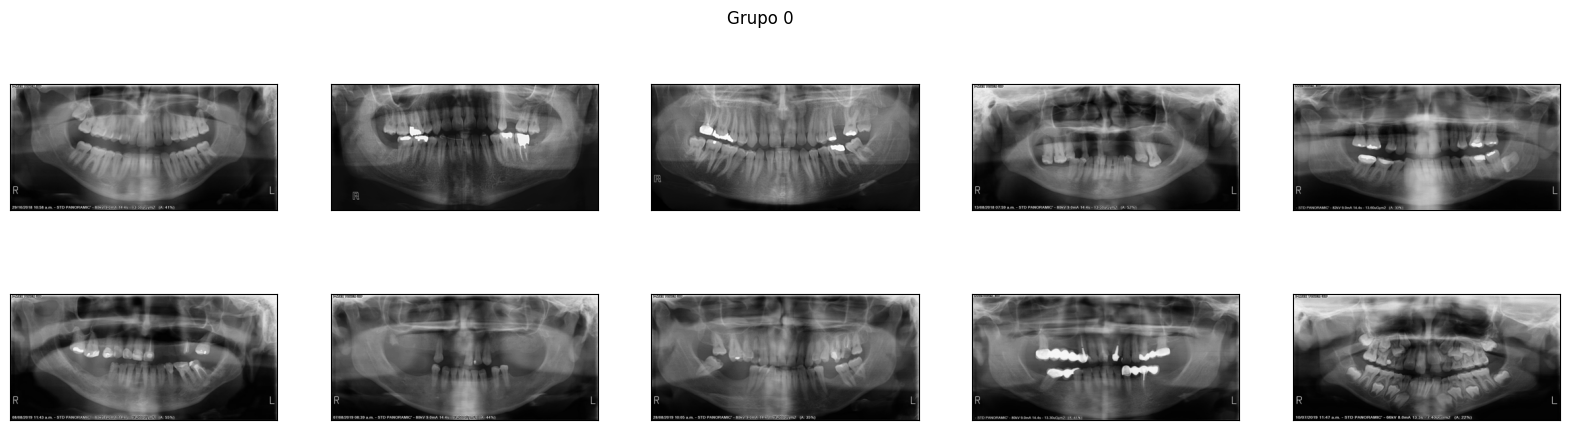

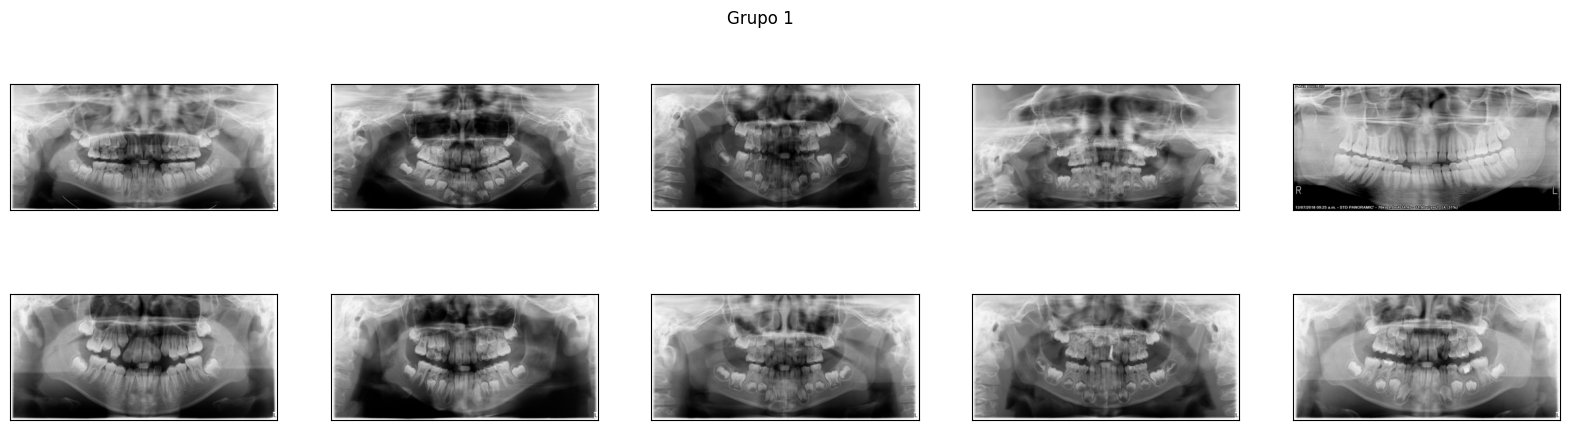

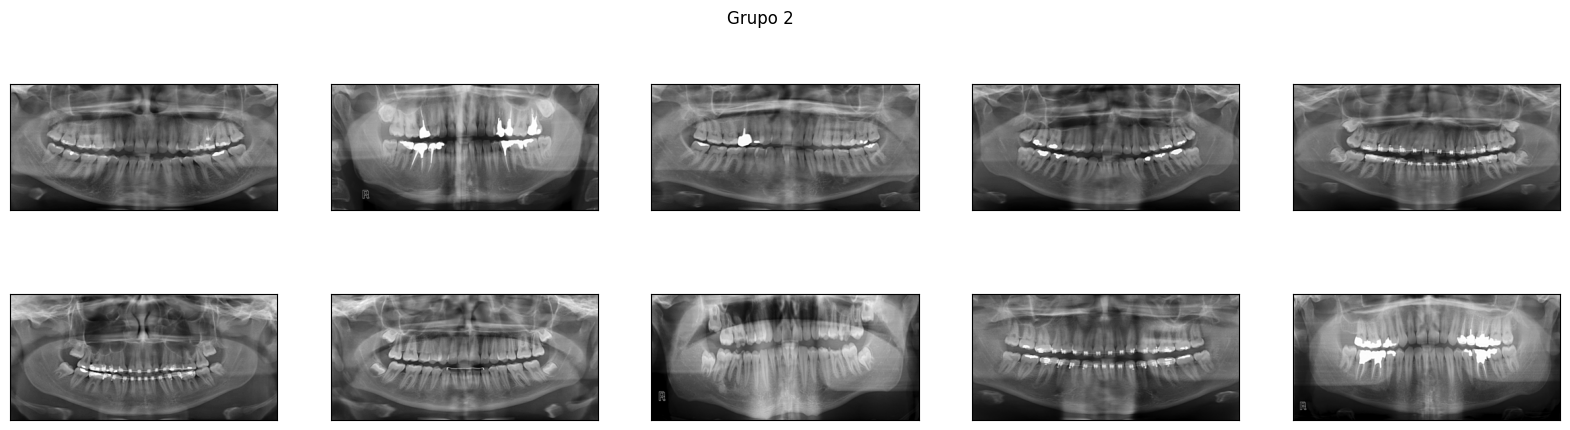

In [20]:
show_images(column='image', c_labels='kmeans_label')

Al analizar y generalizar las características observadas en las imágenes, podemos deducir que los grupos relacionados con las imágenes de adultos corresponden a dentaduras completas e incompletas. Por lo tanto, hemos establecido tres etiquetas para este conjunto de datos: ```child```, ```adult_complete``` y ```adult_incomplete```.

In [21]:
df.loc[df['kmeans_label'] == 1, 'kmeans_label_cat'] = 'child'
df.loc[df['kmeans_label'] == 2, 'kmeans_label_cat'] = 'adult_complete'
df.loc[df['kmeans_label'] == 0, 'kmeans_label_cat'] = 'adult_incomplete'

## Agrupación con filtro aplicando el operador Sobel

El operador Sobel es una herramienta en procesamiento de imágenes diseñada para la detección de bordes. Utiliza convoluciones con matrices específicas para identificar cambios bruscos de intensidad en la imagen, que generalmente corresponden a contornos o bordes

El operador Sobel utiliza dos matrices 3×3, una para detectar los bordes horizontales y otra para los verticales, con los guales podemos aplicar un simple teoriema de pitagoras para obtener la magniturd de cada pixel y obtener dordes mas definidos.

Adicionalmente se us GaussianBlur que es una técnica en procesamiento de imágenes que suaviza una imagen, reduciendo el ruido y los detalles.

Con el fin de optimizar el procesamiento de los datos se utiliza la librería ```cv2``` para la implementación de estas convoluciones.

In [22]:
def apply_filter_sobel(image):
    # Reducimos el ruido con un kernel de 3x3    
    image = cv2.GaussianBlur(image, (3, 3), 0)
    
    # Aplicar Sobel en la dirección X y Y
    sobelX = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobelY = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Calcular la magnitud
    return np.sqrt(sobelX**2 + sobelY**2)

df['image_sabel'] = df['image'].apply(apply_filter_sobel)

In [23]:
predict(column='image_sabel', c_labels='kmeans_sabel_label', n_clusters=3)

Cantidad de iteraciones realizadas: 7


category            Adult  Children  Pediatric
kmeans_sabel_label                            
0                     0.0     100.0      100.0
1                   116.0       0.0        0.0
2                   594.0       0.0        0.0

Al igual que en el ejercicio de contro existe un grupo que detecta en niños y crea dos grupos para los adultos.

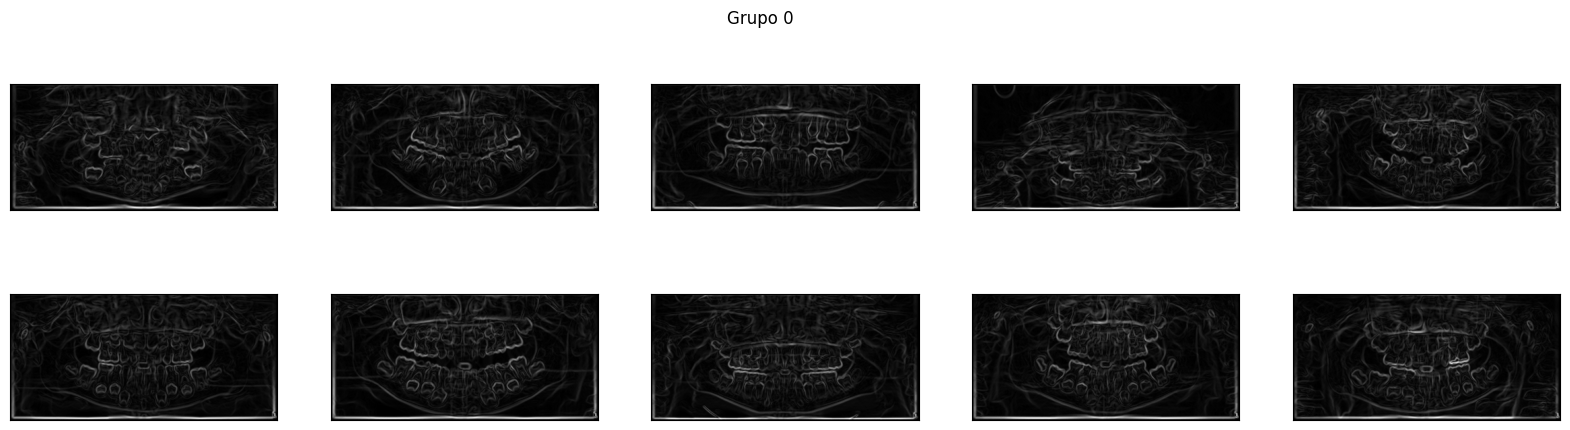

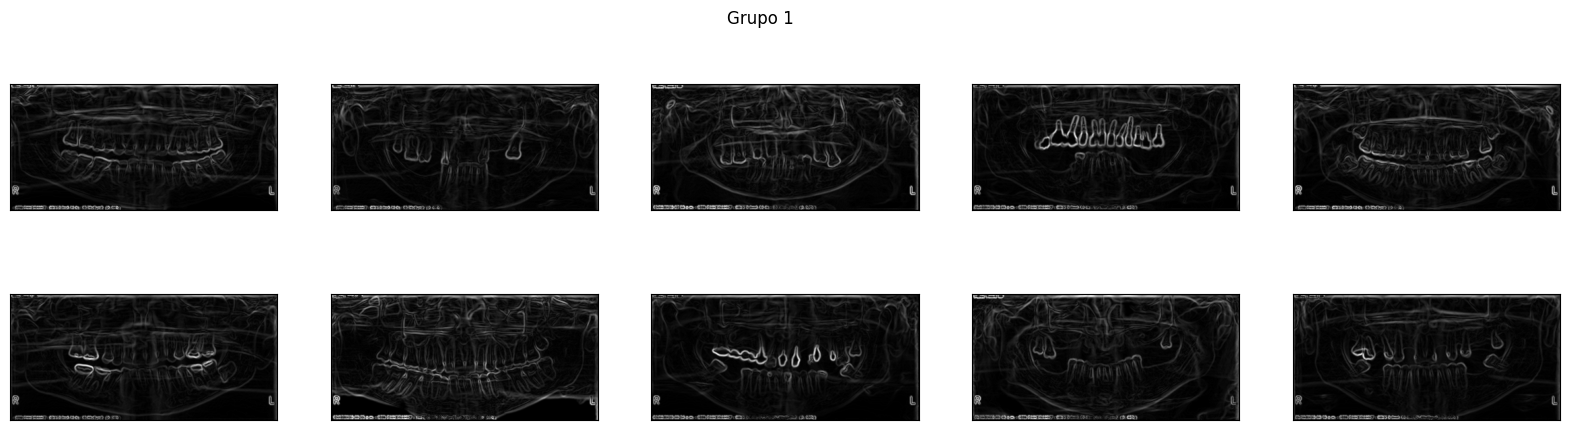

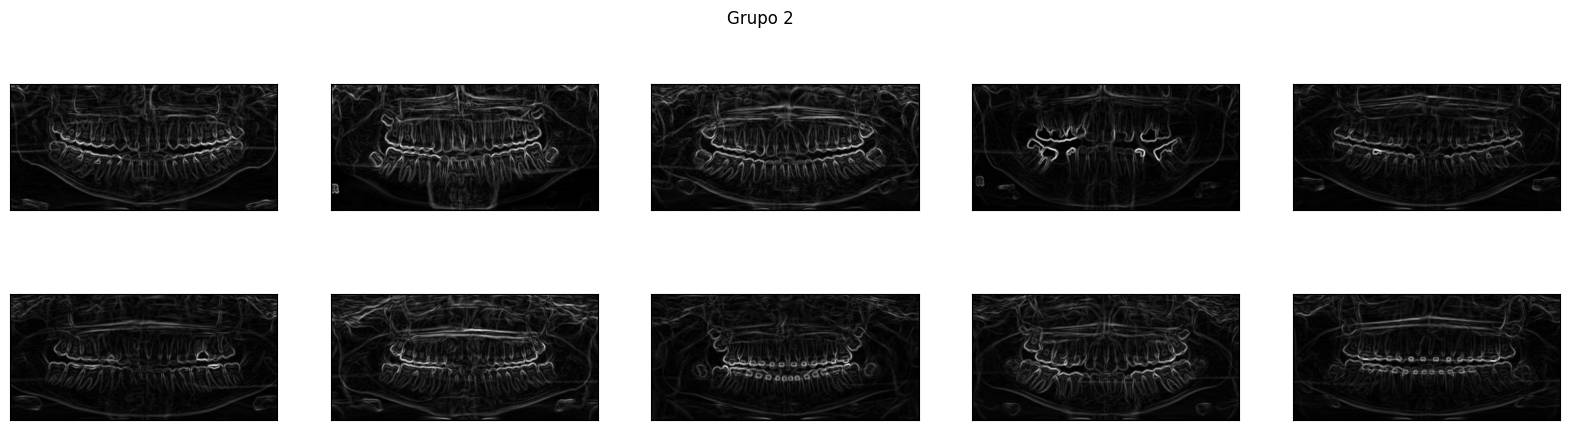

In [ ]:
show_images(column='image_sabel', c_labels='kmeans_sabel_label')

Etiquetamos nuevamente los grupos obtenidos con nuestras 3 etiquetas.

In [25]:
df.loc[df['kmeans_sabel_label'] == 0, 'kmeans_sabel_label_cat'] = 'child'
df.loc[df['kmeans_sabel_label'] == 2, 'kmeans_sabel_label_cat'] = 'adult_complete'
df.loc[df['kmeans_sabel_label'] == 1, 'kmeans_sabel_label_cat'] = 'adult_incomplete'

## Agrupación con filtro usando histograma

En el contexto del procesamiento de imágenes, un histograma es una representación gráfica que muestra la distribución de intensidades de píxeles en una imagen.  A través del histograma, es posible obtener una visión general sobre el contraste, brillo y distribución de tonalidades en una imagen.

In [26]:
df['image_hist'] = df['image'].apply(cv2.equalizeHist)

In [27]:
predict(column='image_hist', c_labels='kmeans_hist_label', n_clusters=3)

Cantidad de iteraciones realizadas: 27


category           Adult  Children  Pediatric
kmeans_hist_label                            
0                  441.0       0.0        0.0
1                  268.0       0.0        0.0
2                    1.0     100.0      100.0

Se detectan comportamientos similares a los previamente observados, pero con un ligero aumento en el grupo minoritario de adultos.

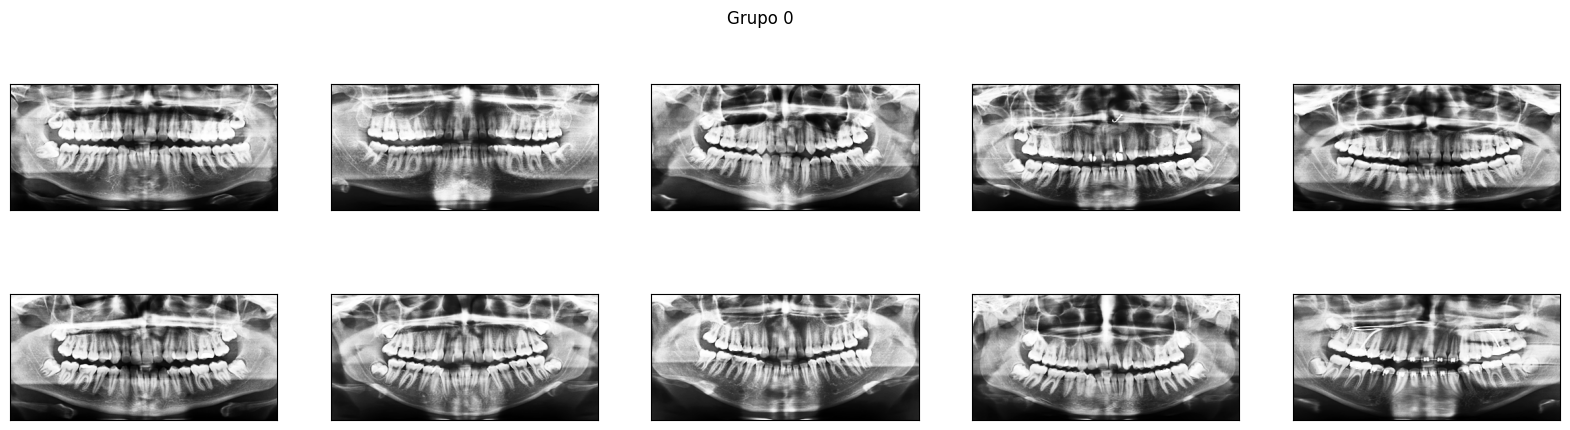

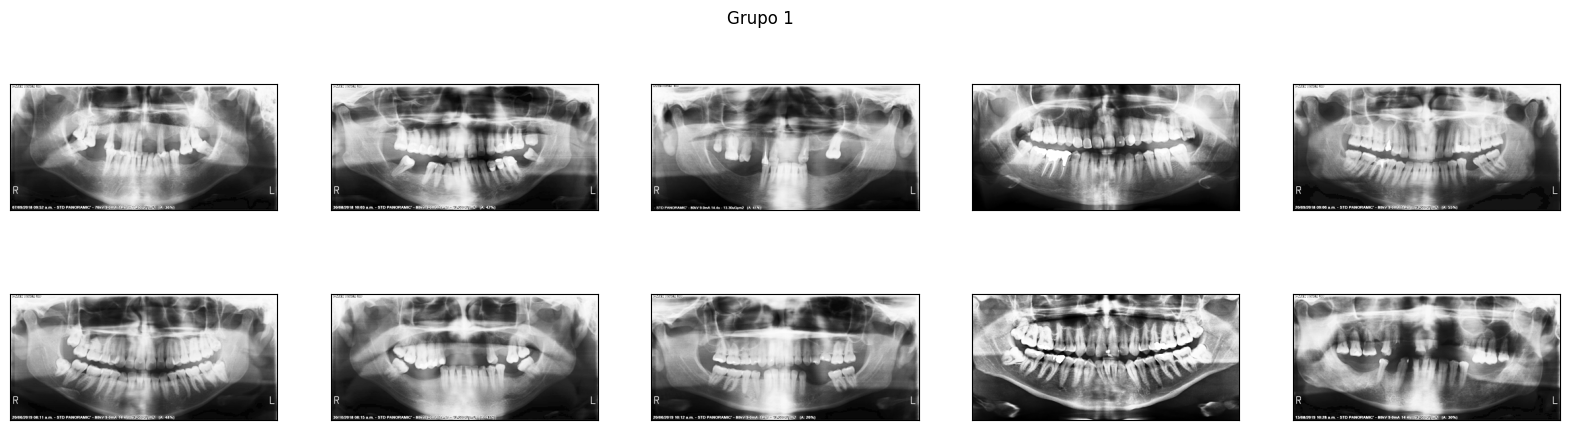

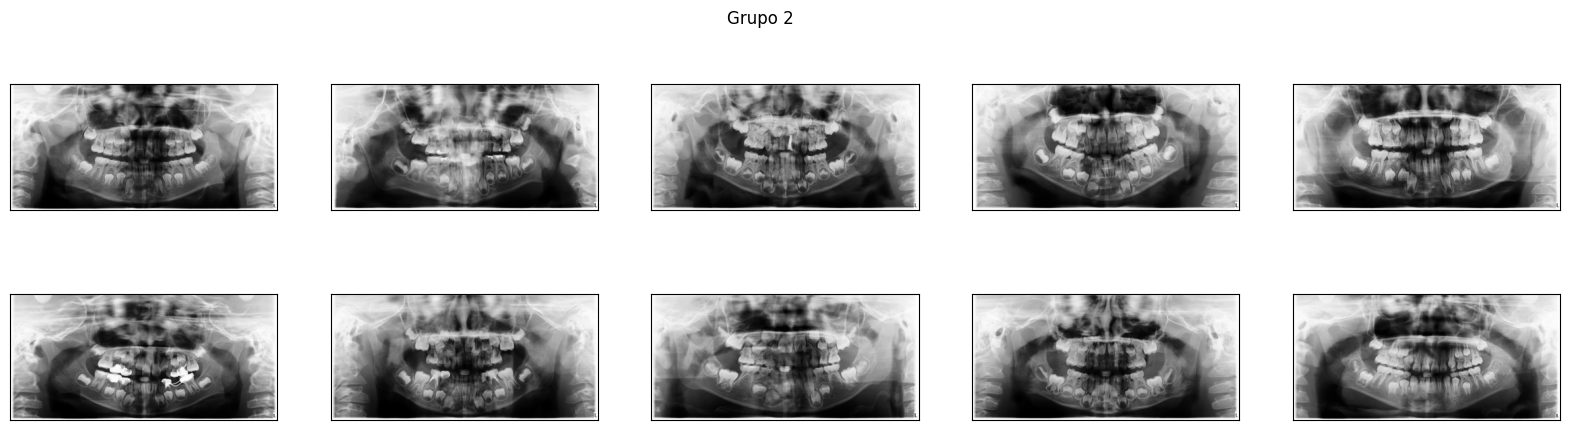

In [ ]:
show_images(column='image_hist', c_labels='kmeans_hist_label')

In [28]:
df.loc[df['kmeans_hist_label'] == 2, 'kmeans_hist_label_cat'] = 'child'
df.loc[df['kmeans_hist_label'] == 0, 'kmeans_hist_label_cat'] = 'adult_complete'
df.loc[df['kmeans_hist_label'] == 1, 'kmeans_hist_label_cat'] = 'adult_incomplete'

## Comparación de categorias

Despues de correr la predicción con distintos tipos de filtros notamos que la categoría de los niños es predicha en un 100%, queremos comparar que características tienen en comun las otras dos categorias de adultos y que filtro se ajusta mas a estas características. Notamos que la categoria de adultos se divide en dentaduras completas e incompletas. 

Por lo que verificamos en cuantas de sus predicciones coincidieron en las 3 agrupaciones.

In [29]:
cat_columns = ['kmeans_label_cat', 'kmeans_sabel_label_cat', 'kmeans_hist_label_cat']

In [30]:
# Obtenemos valores similares 
matched_df = df[(df['kmeans_label_cat'] == df['kmeans_sabel_label_cat']) & (df['kmeans_sabel_label_cat'] == df['kmeans_hist_label_cat'])]
matched_df.shape

(749, 19)

In [31]:
matched_df.groupby('kmeans_label_cat')['kmeans_label_cat'].count()

kmeans_label_cat
adult_complete      438
adult_incomplete    111
child               200
Name: kmeans_label_cat, dtype: int64

In [34]:
not_matched_df = df[~df.index.isin(matched_df.index)]
print('Filas que no coinciden', not_matched_df.shape)


Filas que no coinciden (161, 19)


Observamos que solo 161 registros de adultos no coinciden a través de las tres agrupaciones.

Los tres modelos fallaron en la predicción de esta categoria, ya las dos imagenes corresponden a un adulto con dentadura completa, la segunda imagen podría ser asignada a incompleta. por el estado de los dientes, pero ningún modelo la soció a este grupo.

In [37]:
not_matched_df[['category']+cat_columns].head(50)

category  kmeans_label_cat kmeans_sabel_label_cat kmeans_hist_label_cat
0      Adult    adult_complete         adult_complete      adult_incomplete
1      Adult    adult_complete         adult_complete      adult_incomplete
2      Adult    adult_complete         adult_complete      adult_incomplete
3      Adult    adult_complete         adult_complete      adult_incomplete
4      Adult    adult_complete         adult_complete      adult_incomplete
5      Adult  adult_incomplete         adult_complete      adult_incomplete
6      Adult    adult_complete         adult_complete      adult_incomplete
11     Adult    adult_complete         adult_complete      adult_incomplete
12     Adult  adult_incomplete         adult_complete      adult_incomplete
13     Adult  adult_incomplete         adult_complete      adult_incomplete
14     Adult    adult_complete         adult_complete      adult_incomplete
15     Adult  adult_incomplete       adult_incomplete        adult_complete
18     Adult    adult_complete         adult_complete      adult_incomplete
20     Adult  adult_incomplete         adult_complete      adult_incomplete
21     Adult    adult_complete         adult_complete      adult_incomplete
25     Adult    adult_complete         adult_complete      adult_incomplete
27     Adult    adult_complete         adult_complete      adult_incomplete
28     Adult    adult_complete         adult_complete      adult_incomplete
31     Adult    adult_complete         adult_complete      adult_incomplete
35     Adult    adult_complete       adult_incomplete      adult_incomplete
37     Adult    adult_complete         adult_complete      adult_incomplete
44     Adult    adult_complete         adult_complete      adult_incomplete
49     Adult    adult_complete         adult_complete      adult_incomplete
54     Adult  adult_incomplete         adult_complete      adult_incomplete
55     Adult    adult_complete         adult_complete      adult_incomplete
56     Adult    adult_complete         adult_complete      adult_incomplete
57     Adult  adult_incomplete         adult_complete      adult_incomplete
59     Adult    adult_complete         adult_complete      adult_incomplete
60     Adult    adult_complete         adult_complete      adult_incomplete
61     Adult    adult_complete         adult_complete      adult_incomplete
62     Adult    adult_complete         adult_complete      adult_incomplete
63     Adult    adult_complete       adult_incomplete      adult_incomplete
67     Adult    adult_complete         adult_complete      adult_incomplete
68     Adult    adult_complete         adult_complete      adult_incomplete
69     Adult  adult_incomplete         adult_complete      adult_incomplete
73     Adult    adult_complete         adult_complete      adult_incomplete
76     Adult    adult_complete         adult_complete      adult_incomplete
78     Adult    adult_complete         adult_complete      adult_incomplete
79     Adult    adult_complete         adult_complete      adult_incomplete
80     Adult    adult_complete         adult_complete      adult_incomplete
82     Adult    adult_complete         adult_complete      adult_incomplete
86     Adult    adult_complete         adult_complete      adult_incomplete
87     Adult    adult_complete         adult_complete      adult_incomplete
88     Adult    adult_complete         adult_complete      adult_incomplete
90     Adult    adult_complete         adult_complete      adult_incomplete
92     Adult  adult_incomplete         adult_complete      adult_incomplete
94     Adult    adult_complete         adult_complete      adult_incomplete
98     Adult    adult_complete         adult_complete      adult_incomplete
102    Adult    adult_complete         adult_complete      adult_incomplete
110    Adult    adult_complete         adult_complete      adult_incomplete

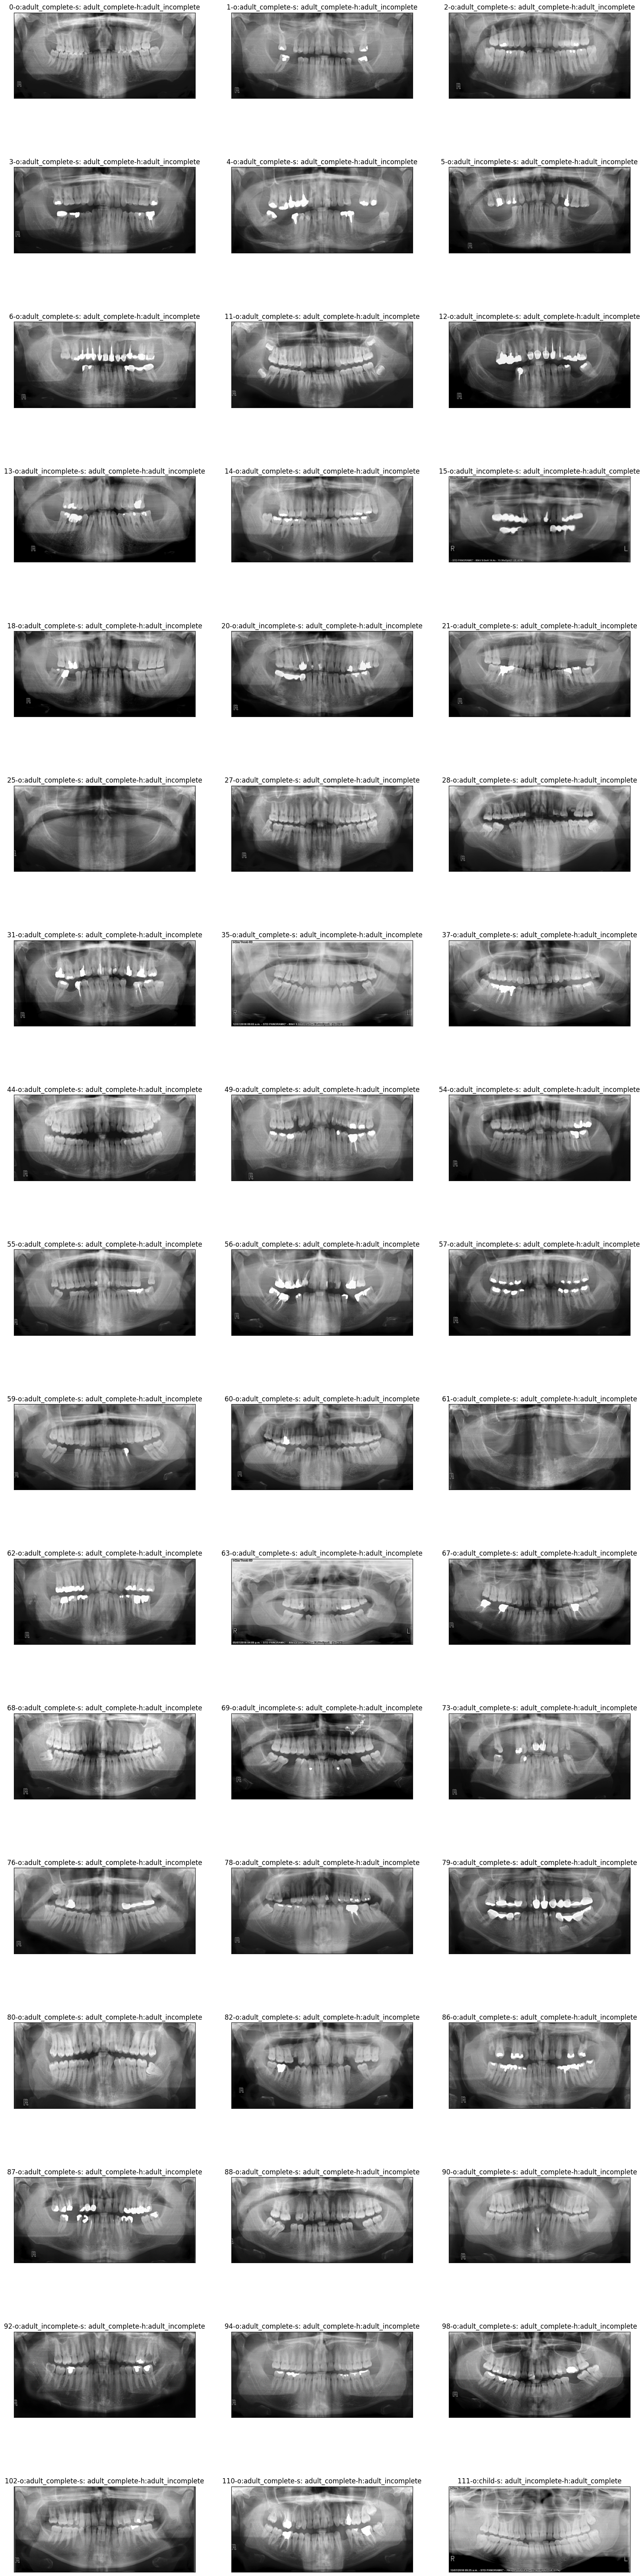

In [42]:
import math

nrows = math.ceil(50/3)
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20, nrows*5))

axs = axes.ravel()
first_indices = not_matched_df.index[:51]
for i, idx in enumerate(first_indices):    
    row = not_matched_df.loc[idx]
    title = f'o:{row.kmeans_label_cat}-s: {row.kmeans_sabel_label_cat}-h:{row.kmeans_hist_label_cat}'
    axs[i].set_title(f'{idx}-{title}')
    axs[i].imshow(row['image'], cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.show()


Se llevó a cabo una validación y etiquetado manual de una selección de imágenes que no presentaron coincidencias en las tres agrupaciones previas. Este proceso ayudará en determinar cuál fue el filtro más efectivo para la agrupación."

In [44]:
visual_validation = [
    (0,'adult_incomplete'),
	(1,'adult_incomplete'),
	(3,'adult_incomplete'),
	(4,'adult_incomplete'),
	(5,'adult_incomplete'),
	(5,'adult_incomplete'),
	(6,'adult_incomplete'),
	(12,'adult_incomplete'),
	(13,'adult_incomplete'),
	(14,'adult_incomplete'),
	(15,'adult_incomplete'),
	(18,'adult_incomplete'),
	(21,'adult_incomplete'),
	(25,'adult_incomplete'),
	(28,'adult_incomplete'),
	(31,'adult_incomplete'),
	(35,'adult_incomplete'),
	(55,'adult_incomplete'),
	(56,'adult_incomplete'),
	(59,'adult_incomplete'),
	(60,'adult_incomplete'),
	(67,'adult_incomplete'),
	(68,'adult_complete'),
	(69,'adult_incomplete'),
	(73,'adult_incomplete'),
	(82,'adult_incomplete'),
	(86,'adult_incomplete'),
	(87,'adult_incomplete'),
	(88,'adult_incomplete'),
	(98,'adult_incomplete'),
	(110,'adult_incomplete'),
	(115,'adult_incomplete'),
	(121,'adult_incomplete'),
	(122,'adult_incomplete'),
	(123,'adult_incomplete'),
	(124,'adult_incomplete'),
	(129,'adult_incomplete'),
	(130,'adult_incomplete'),
	(131,'adult_incomplete'),
	(138,'adult_complete'),
	(139,'adult_incomplete'),
	(141,'adult_incomplete'),
	(144,'adult_incomplete'),
	(145,'adult_incomplete'),
	(147,'adult_incomplete'),
	(148,'adult_incomplete'),
	(149,'adult_complete'),
	(150,'adult_complete'),
	(153,'adult_incomplete'),
	(155,'adult_complete'),
	(156,'adult_incomplete'),
	(157,'adult_incomplete'),
]

visual_validation = pd.DataFrame(visual_validation)
visual_validation.set_index(visual_validation.columns[0], inplace=True)

In [46]:
to_compre_df = not_matched_df.loc[visual_validation.index.tolist()][cat_columns]
to_compre_df['to_compare'] = visual_validation[1]
to_compre_df.kmeans_label_cat = to_compre_df.kmeans_label_cat == to_compre_df['to_compare']
to_compre_df.kmeans_sabel_label_cat = to_compre_df.kmeans_sabel_label_cat == to_compre_df['to_compare']
to_compre_df.kmeans_hist_label_cat = to_compre_df.kmeans_hist_label_cat == to_compre_df['to_compare']

to_compre_df.groupby('to_compare')[cat_columns].sum()

kmeans_label_cat  kmeans_sabel_label_cat   
to_compare                                                   
adult_complete                   4                       5  \
adult_incomplete                 7                       2   

                  kmeans_hist_label_cat  
to_compare                               
adult_complete                        0  
adult_incomplete                     46

Tras nuestro análisis exhaustivo, hemos observado que el filtro basado en histogramas demuestra una capacidad distintiva para detectar dentaduras incompletas. Esta habilidad es especialmente prominente en comparación con los otros dos filtros evaluados. Esto sugiere que el enfoque del histograma podría tener una mayor sensibilidad o precisión en la identificación de características específicas relacionadas con las dentaduras incompletas."